# TF acs-2 fluorescence

In [18]:
import os
import sys
import tifffile as tiff
import textwrap as tw
import csv
import pandas
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import itertools as IT
import time


import skimage
from skimage import io as skio
from skimage import color

from skimage.feature import peak_local_max

import glob



sys.path.append("./src")


from utilities import *



In [19]:
## Some adjustments

#matplotlib.use('MacOSX') # For visualising
#matplotlib.use('Agg') # For saving
#matplotlib.use('MacOSX') #TkAgg

#plt.interactive(True)
matplotlib.rcParams.update({'font.size': 12})
np.set_printoptions(precision=3)

In [20]:
os.chdir("/home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/")
odir="."
sourceloc = "/home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/"

In [21]:
## Test images

### Settings

step = 0.001
levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]


indo = 0.0

sthres=1000
cthres=0.02
size=1000

In [163]:
### Select file

files=glob.glob("./Rep2*/*/fur metf*.tiff")

fl=files[6]


rep,fol,filt=fl.split('/')[1:]
fil=filename(filt)[1]

print fl


./Rep2_24-8-17/fur metf/fur metf6.tiff


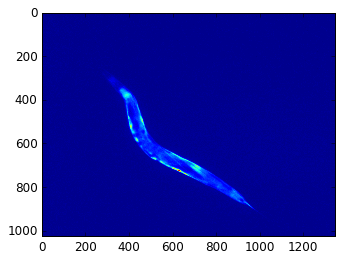

In [164]:
### Load image

image = tiff.imread(fl)

imghsv = color.rgb2hsv(image)
imgrgb = color.hsv2rgb(imghsv)

gray = color.rgb2gray(image)
image_rescale=exposure.rescale_intensity(image)

#Image dimensions
image.shape

### Label worms
image_jet=jetimage(gray)

plt.imshow(image_jet)

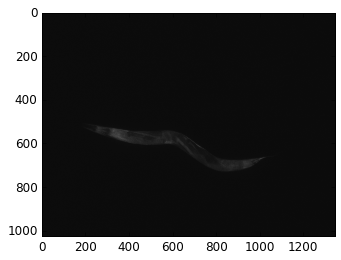

In [123]:
plt.imshow(image)

FWHM: 0.00371934261029, mu: 0.0442901371253, SD: 0.00157945938083


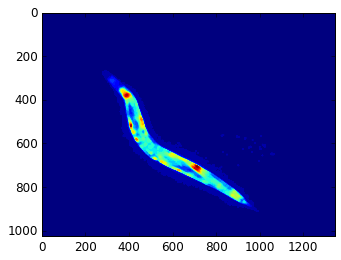

In [165]:
v = imghsv[:, :, 2]

# Filtering noise
dv = rank.median(v, disk(3)) / 255.0
#Expanding 
comb = opening(dv, selem=disk(5))

v1D = np.around(v.ravel(), 3)
ftable = np.array(freqtable(v1D))
ftable = ftable[np.argsort(ftable[:, 0])]
X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])

#Save image
skio.imsave('{}_{}_{}_adjusted_RGB.tiff'.format(rep,fol,fil),jetimage(comb))

plt.imshow(comb)

Threshold: 0.0400, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0410, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0420, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0430, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0440, Worm size: 108993 Image covered: 7.92%
Threshold: 0.0450, Worm size: 108993 Image covered: 7.92%
Threshold: 0.0460, Worm size: 108993 Image covered: 7.92%
Threshold: 0.0470, Worm size: 108993 Image covered: 7.92%
Threshold: 0.0480, Worm size: 59827 Image covered: 4.35%
Threshold: 0.0490, Worm size: 59827 Image covered: 4.35%
Threshold: 0.0500, Worm size: 59827 Image covered: 4.35%
Threshold: 0.0510, Worm size: 54410 Image covered: 3.95%
0.052
3.95347958519


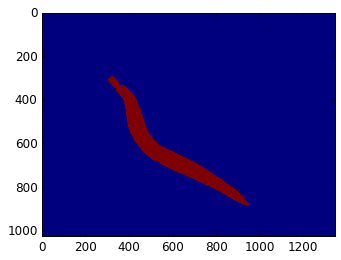

In [166]:
hthr=mu + sd * 0.5

umarks=[0]
wsize=0
imgprc=100

iter=0
total=np.sum(comb >0)

hthri=0.04
step=0.001

#wsize < 45000 or wsize > 55000 or 
while (wsize < 40000 or wsize > 55000 or imgprc<3 or imgprc>5) and iter<100 and hthri<0.06:
    markers = np.zeros_like(comb)
    # Mark background
    imgprc=np.float(np.sum(comb > hthri)*100)/total
    
    markers[comb > hthri] = 2
    umarks=np.unique(markers)
    wsize=np.count_nonzero(markers[markers==2])
    print("Threshold: {:.4f}, Worm size: {:d} Image covered: {:.2f}%".format(hthri,wsize,imgprc))
    hthri+=step
    iter+=1

markers[comb == 0] = 1

print(hthri)
print(imgprc)
plt.imshow(markers)

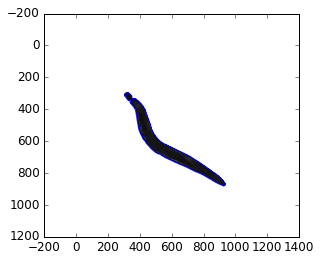

In [167]:
distance = ndi.distance_transform_edt(markers)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=markers)
markersmaxi = ndi.label(local_maxi)[0]
segmentation = watershed(distance, markersmaxi, mask=markers)
segmentation_fill = ndi.binary_fill_holes(segmentation)
labeled_worms, _ = ndi.label(segmentation_fill)
#plt.imshow(labeled_worms)

for w in list(np.unique(labeled_worms)):
    # print labeled_worms[labeled_worms==w].shape[0]
    if labeled_worms[labeled_worms == w].shape[0] < size:
        labeled_worms[labeled_worms == w] = 0
        
labeled_worms = opening(labeled_worms, selem=disk(10))

wormind = list(np.unique(labeled_worms))
worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}

#Make white background
extract = imgrgb.copy()
extract[labeled_worms == 0, :] = [1, 1, 1]

contours = measure.find_contours(labeled_worms, 0.8)

plt.figure()

plt.imshow(extract)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.show()